In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
import time
from pyDOE import lhs
from PIL import Image

np.random.seed(1234)
tf.random.set_seed(1234)


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
alp= np.linspace(0,1,3000)
alp_uvtest = tf.reshape(alp,[3000,1])
lb = alp_uvtest[0]
ub = alp_uvtest[-1]


# *Test Data*

We prepare the test data to compare against the solution produced by the PINN.

# *Training Data*

The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [3]:
%matplotlib inline
#open the target pic
demo = Image.open("D:/SCUT/Academic/update/input2.png")
width, heigth = demo.size
grey = demo.convert('L')

grey = np.array(grey)
col1 = np.zeros([708,1])
for i in range(0,707):
    col1[i,0] = 255

for i in range(0,28):
    grey = np.hstack((grey,col1))

us = np.linspace(-1,1,1002)
vs = np.zeros(1002)
for i in range(1,1001):
    mini = np.argmin(grey[:,i-1])
    vs[i] = mini
    vs[i] = (707-vs[i])*(0.4/707)
vs[1001]=0

d = np.zeros(1001)
for i in range(len(d)):
    d[i] = ((us[i+1]-us[i])**2+(vs[i+1]-vs[i])**2)**0.5

index = np.zeros(1002)
for i in range(0,1000):
    mini = np.argmin(grey[:,i])
    index[i] = mini

for i in range(0,1000):
    index[i] = (707-index[i])*(0.4/707)

index[500:1000] = 0
index = np.reshape(index,(1002,1))

indexu = np.reshape(np.linspace(-1,1,1002),(1002,1))
for i in range(0,1001):
    indexu[i,0] = indexu[i+1,0]
indexu[1000,0] = -1
indexu[1001,0] = 1
print(index)
print(indexu)


[[0.00056577]
 [0.00678925]
 [0.01640736]
 ...
 [0.        ]
 [0.        ]
 [0.        ]]
[[-0.998002  ]
 [-0.996004  ]
 [-0.99400599]
 ...
 [ 0.998002  ]
 [-1.        ]
 [ 1.        ]]


In [4]:
def trainingdata1(N_f):
    '''boundary'''

    #left
    leftedge_alp = 0
    leftedge_u = -1
    leftedge_v = 0

    #right
    rightedge_alp = 1
    rightedge_u = 1
    rightedge_v = 0

    alp_uvtrain = np.vstack([leftedge_alp, rightedge_alp])
    u_train = np.vstack([leftedge_u, rightedge_u])
    v_train = np.vstack([leftedge_v, rightedge_v])

    # Latin Hypercube sampling for collocation points
    tempalp = np.zeros(N_f+1)
    for i in range(len(tempalp)):
        if i+1 <= 1000:
            tempalp[i+1] = tempalp[i]+(d[i]/(np.sum(d)))
    alp_f_train = np.zeros(1000)
    for i in range (len(alp_f_train)):
        alp_f_train[i] = tempalp[i+1]
    alp_f_train = tf.reshape(alp_f_train,(N_f,1))
    alp_f_train = np.vstack((alp_f_train, alp_uvtrain)) 

    return alp_f_train, alp_uvtrain, u_train, v_train

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [5]:
class PertudynNN1(tf.Module): 
    def __init__(self,layers, name = None):
        self.W = []
        self.parameters = 0
        
        for i in range(len(layers)-1):
            input_dim = layers[i]
            output_dim = layers[i+1]

            std_dv = np.sqrt((2.0/(input_dim + output_dim)))
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim

    def evaluate(self,alp):
        alp = (alp-lb)/(ub-lb)
        a = alp
        for i in range(len(layers)-2):
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) 
        return a
    
    def get_weights(self):

        parameters_1d = []  
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 
    
    def loss_BC(self,alp,yu,yv):

        loss_u = tf.reduce_sum(tf.square(yu-tf.reshape((self.evaluate(alp)[:,0]),(2,1))))
        loss_v = tf.reduce_sum(tf.square(yv-tf.reshape((self.evaluate(alp)[:,1]),(2,1))))
        return loss_u, loss_v

    def loss_PDE(self, alp_to_train_f):
        
        g = tf.Variable(alp_to_train_f, dtype = 'float64', trainable = False)
        alp_f = g
        loss1 = tf.reduce_mean(tf.square(indexu-tf.reshape((self.evaluate(alp_f)[:,0]),(N_f+2,1))))
        loss2 = tf.reduce_mean(tf.square(index-tf.reshape((self.evaluate(alp_f)[:,1]),(N_f+2,1))))
        loss_f = loss1+loss2
        """
        with tf.GradientTape(persistent=True) as tape:

            tape.watch(alp_f)
            z = self.evaluate(alp_f)
            u = tf.reshape(z[:,0],(N_f+2,1))
            v = tf.reshape(z[:,1],(N_f+2,1))
            u_x = tape.gradient(u,alp_f)
            v_x = tape.gradient(v,alp_f)
            lda2temp1 = ((u-u*u*u-10*u*v*v)*(u-u*u*u-10*u*v*v)+v*v*(1+u*u)*(1+u*u))
            lda2temp1 = tf.reshape(lda2temp1,[N_f+2,1])
            lda2temp2 = (u_x*u_x+v_x*v_x)
            lda2 = lda2temp1/lda2temp2
            
        
        lda2_x = tape.gradient(lda2,alp_f)
        u_xx = tape.gradient(u_x, alp_f)
        v_xx = tape.gradient(v_x, alp_f)

        del tape
        temp1 = tf.reshape((-4*(u*u*u)+3*(u*u*u*u*u)+60*(u*u*u)*(v*v)+100*u*(v*v*v*v)+u),(N_f+2,1))
        temp2 = tf.reshape((3*(u*u*u*u*v) + 20*(u*u)*(v*v*v)+v),(N_f+2,1))
        f1 = lda2 * u_xx - temp1 + 0.5*lda2_x*u_x
        f2 = lda2 * v_xx - temp2 + 0.5*lda2_x*v_x
        loss_f = tf.reduce_mean(tf.square(f1))+tf.reduce_mean(tf.square(f2))
        """
        return loss_f
        
        
    def loss(self,alp,yu,yv,g):

        loss_u, loss_v = self.loss_BC(alp,yu,yv)
        loss_f = self.loss_PDE(g)

        loss = loss_u + loss_v + loss_f

        return loss, loss_u, loss_v, loss_f    

    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_v, loss_f = self.loss(alp_uvtrain, u_train, v_train, alp_f_train)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()

    def optimizer_callback(self,parameters):
               
        loss_value, loss_u,loss_v, loss_f = self.loss(alp_uvtrain, u_train, v_train, alp_f_train)     
        tf.print(loss_value, loss_u,loss_v, loss_f)

0.83938076554087426 0.69416426116492924 1.5191796987331996e-05 0.14520131257895777
0.582648138713051 0.47840890212006087 0.0008494600491902399 0.10338977654379991
0.20698047589336807 0.15152771788006378 0.0016693680609390408 0.053783389952365264
0.048895650004350762 0.010439920334027859 0.0061014704519239283 0.032354259218398976
0.033989047139161233 0.0041123050536236013 0.0019184526732442862 0.027958289412293343
0.033164740509010894 0.0034189073534983878 0.0028679676750318489 0.02687786548048066
0.032852918179841775 0.0034671021551595993 0.0034146583897759035 0.025971157634906275
0.032105381446598427 0.0032186673310043885 0.0048117500290491139 0.024074964086544925
0.031170030387449175 0.0031997746914222279 0.0060811139619758132 0.021889141734051133
0.028584185958768694 0.0030109320476534875 0.0081221003041441666 0.01745115360697104
0.0261807867518017 0.0024127569161928059 0.0069045298828625335 0.016863499952746358
0.022820891724395054 0.00065506326429030156 0.0028364119012620486 0.019

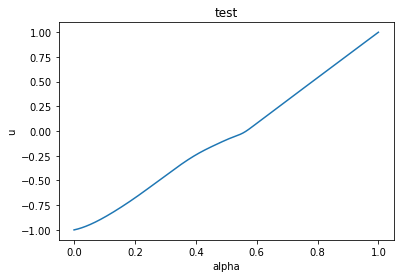

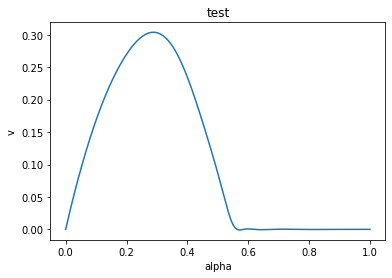

In [6]:
N_f = 1000 #Total number of collocation points 

# Training data
alp_f_train, alp_uvtrain, u_train, v_train = trainingdata1(N_f)

layers = np.array([1,20,20,20,20,2]) #2 hidden layers

PINN = PertudynNN1(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 200, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 5e-8, 
                                            'maxfun':  50000, 
                                            'maxiter':5000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})

elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

# print(results)

PINN.set_weights(results.x)
u_pred = PINN.evaluate(alp_uvtest)[:,0]
v_pred = PINN.evaluate(alp_uvtest)[:,1]

fig,ax = plt.subplots()
plt.plot(alp_uvtest,u_pred)
plt.xlabel('alpha')
plt.ylabel('u')
plt.title('test')
plt.show()

fig,ax = plt.subplots()
plt.plot(alp_uvtest,v_pred)
plt.xlabel('alpha')
plt.ylabel('v')
plt.title('test')
plt.show()

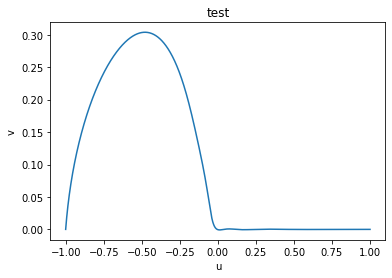

In [7]:
newtest= np.linspace(0,1,10000)
new_alp_uvtest = tf.reshape(newtest,[10000,1])

u_pred_new = PINN.evaluate(new_alp_uvtest)[:,0]
v_pred_new = PINN.evaluate(new_alp_uvtest)[:,1]

fig,ax = plt.subplots()
plt.plot(u_pred_new,v_pred_new)
plt.xlabel('u')
plt.ylabel('v')
plt.title('test')
plt.show()

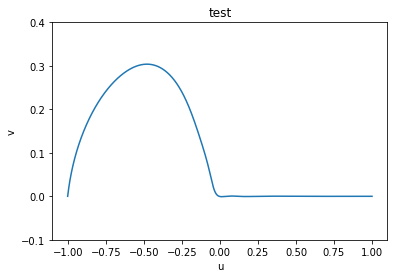

In [8]:
fig,ax = plt.subplots()
plt.plot(u_pred_new,v_pred_new)
plt.xlabel('u')
plt.ylabel('v')
plt.title('test')
plt.ylim([-0.1, 0.4])
plt.show()



In [9]:
weightsI = results.x

In [10]:
def trainingdata2(N_f):
    '''boundary'''

    #left
    leftedge_alp = 0
    leftedge_u = -1
    leftedge_v = 0

    #right
    rightedge_alp = 1
    rightedge_u = 1
    rightedge_v = 0

    alp_uvtrain = np.vstack([leftedge_alp, rightedge_alp])
    u_train = np.vstack([leftedge_u, rightedge_u])
    v_train = np.vstack([leftedge_v, rightedge_v])

    # Latin Hypercube sampling for collocation points
    alp_f_train = lb + (ub-lb)*lhs(1,N_f)
    alp_f_train = np.vstack((alp_f_train, alp_uvtrain)) 

    return alp_f_train, alp_uvtrain, u_train, v_train

In [11]:
class PertudynNN2(tf.Module): 
    def __init__(self,layers, name = None):
        self.W = []
        self.parameters = 0
        
        for i in range(len(layers)-1):
            input_dim = layers[i]
            output_dim = layers[i+1]

            std_dv = np.sqrt((2.0/(input_dim + output_dim)))
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim

    def evaluate(self,alp):
        alp = (alp-lb)/(ub-lb)
        a = alp
        for i in range(len(layers)-2):
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) 
        return a
    
    def get_weights(self):

        parameters_1d = []  
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 
    
    def loss_BC(self,alp,yu,yv):

        loss_u = tf.reduce_sum(tf.square(yu-tf.reshape((self.evaluate(alp)[:,0]),(2,1))))
        loss_v = tf.reduce_sum(tf.square(yv-tf.reshape((self.evaluate(alp)[:,1]),(2,1))))
        return loss_u, loss_v

    def loss_PDE(self, alp_to_train_f):
        g = tf.Variable(alp_to_train_f, dtype = 'float64', trainable = False)
        alp_f = g
        with tf.GradientTape(persistent=True) as tape:

            tape.watch(alp_f)
            z = self.evaluate(alp_f)
            u = tf.reshape(z[:,0],(N_f+2,1))
            v = tf.reshape(z[:,1],(N_f+2,1))
            u_x = tape.gradient(u,alp_f)
            v_x = tape.gradient(v,alp_f)
            #lda2 = (tf.pow((z[:,0]-tf.pow(z[:,0],3)-z[:,0]*tf.pow(z[:,1],2)),2) + tf.pow(z[:,1],2)*tf.pow((1+tf.pow(z[:,0],2)),2))/(tf.pow(u_x,2)*tf.pow(v_x,2))
            lda2temp1 = ((u-u*u*u-u*v*v)*(u-u*u*u-u*v*v)+v*v*(1+u*u)*(1+u*u))
            lda2temp1 = tf.reshape(lda2temp1,[N_f+2,1])
            lda2temp2 = (u_x*u_x+v_x*v_x)
            lda2 = lda2temp1/lda2temp2
        lda = tf.sqrt(lda2)
        lda2_x = tape.gradient(lda2,alp_f)
        u_xx = tape.gradient(u_x, alp_f)
        v_xx = tape.gradient(v_x, alp_f)

        del tape
        temp1 = tf.reshape((-4*(u*u*u)+3*(u*u*u*u*u)+42*(u*u*u)*(v*v)+100*u*(v*v*v*v)+u-18*u*v*v),(N_f+2,1))
        temp2 = tf.reshape((-18*u*u*v+21*u*u*u*u*v+200*u*u*v*v*v+v),(N_f+2,1))
        #f = lda2 * u_xx + (-4*(z[:,0]**3)+3*(z[:,0]**5)+6*(z[:,0]**3)*(z[:,0]**2)+z[:,0]*(z[:,1]**4)+z[:,0]) + 0.5*lda2_x*u_x + lda2 * v_xx - 3*(z[:,0]**4)*z[:,1] + 2*(z[:,0]**2)*(z[:,1]**3)+z[:,1]+0.5*lda2_x*v_x
        temp3 = -18*u*v*v_x
        temp4 = 18*u*v*u_x

        f1 = lda2 * u_xx - temp1 - lda*temp3 + 0.5*lda2_x*u_x
        f2 = lda2 * v_xx - temp2 - lda*temp4 + 0.5*lda2_x*v_x

        loss_f = tf.reduce_mean(tf.square(f1))+tf.reduce_mean(tf.square(f2))
        #loss_f = tf.reduce_mean(tf.square(f1+f2))
        """
        f = lda2 * u_xx + temp1 + 0.5*lda2_x*u_x + lda2 * v_xx + temp2 +0.5*lda2_x*v_x
        loss_f = tf.reduce_mean(tf.square(f))
        """

        return loss_f

    def loss(self,alp,yu,yv,g):

        loss_u, loss_v = self.loss_BC(alp,yu,yv)
        loss_f = self.loss_PDE(g)

        loss = loss_u + loss_v + loss_f

        return loss, loss_u, loss_v, loss_f    

    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_v, loss_f = self.loss(alp_uvtrain, u_train, v_train, alp_f_train)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()

    def optimizer_callback(self,parameters):
               
        loss_value, loss_u,loss_v, loss_f = self.loss(alp_uvtrain, u_train, v_train, alp_f_train)     
        tf.print(loss_value, loss_u,loss_v, loss_f)

0.0054577450067855842 7.0574756586702743e-06 0.00024496423171747325 0.0052057232994094406
0.0049991316692800311 2.2222907344906891e-06 0.00043733564006748747 0.0045595737384780529
0.0048168928468543043 4.7311180870019192e-07 0.00040593060906973615 0.0044104891259758678
0.0044633975325728877 2.6575041014954764e-05 0.00039392032860729363 0.0040429021629506392
0.0042942921268963076 6.6080710272909516e-05 0.00039635381311393979 0.0038318576035094583
0.004032847564078906 4.9049308473837874e-05 0.00026703179639489283 0.0037167664592101749
0.0037929338461972131 1.4459869286969079e-05 3.6230096626817594e-05 0.0037422438802834266
0.003654452829659018 2.7896543443089668e-06 1.3843875858545497e-05 0.0036378192994561635
0.0036312501362489322 4.1226215538869543e-06 1.1246299220712612e-05 0.0036158812154743324
0.0035832808771080406 5.2074798524303155e-06 6.6495138891478626e-06 0.0035714238833664622
0.0035375759973704192 2.50934492501944e-06 4.0095552424289533e-06 0.0035310570972029707
0.003487546703

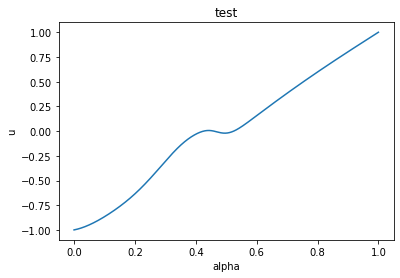

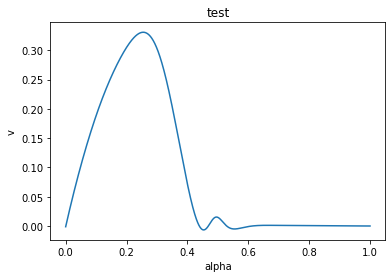

In [12]:
N_f = 1000 #Total number of collocation points 

# Training data
alp_f_train, alp_uvtrain, u_train, v_train = trainingdata2(N_f)

layers = np.array([1,20,20,20,20,2]) #2 hidden layers

PINN2 = PertudynNN2(layers)

PINN2.set_weights(weightsI)

init_params = PINN2.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN2.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN2.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 200, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 5e-8, 
                                            'maxfun':  50000, 
                                            'maxiter': 5000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})

elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))

# print(results)

PINN2.set_weights(results.x)
u_pred = PINN2.evaluate(alp_uvtest)[:,0]
v_pred = PINN2.evaluate(alp_uvtest)[:,1]

fig,ax = plt.subplots()
plt.plot(alp_uvtest,u_pred)
plt.xlabel('alpha')
plt.ylabel('u')
plt.title('test')
plt.show()

fig,ax = plt.subplots()
plt.plot(alp_uvtest,v_pred)
plt.xlabel('alpha')
plt.ylabel('v')
plt.title('test')
plt.show()

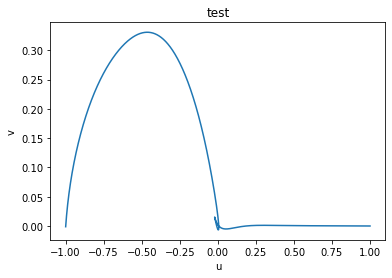

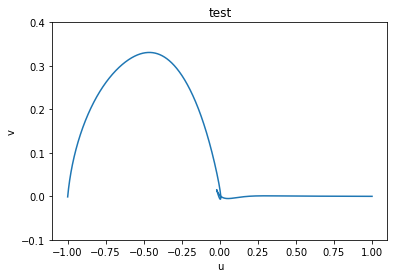

In [13]:
newtest= np.linspace(0,1,10000)
new_alp_uvtest = tf.reshape(newtest,[10000,1])

u_pred_new = PINN2.evaluate(new_alp_uvtest)[:,0]
v_pred_new = PINN2.evaluate(new_alp_uvtest)[:,1]

fig,ax = plt.subplots()
plt.plot(u_pred_new,v_pred_new)
plt.xlabel('u')
plt.ylabel('v')
plt.title('test')
plt.show()

fig,ax = plt.subplots()
plt.plot(u_pred,v_pred)
plt.xlabel('u')
plt.ylabel('v')
plt.title('test')
plt.ylim([-0.1, 0.4])
plt.show()